# Convolutional Neural Network

<p align='center'>
<img src='https://cdn-images-1.medium.com/max/1600/1*NQQiyYqJJj4PSYAeWvxutg.png' width='700'>

So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

Here You will be implementing the building blocks of a convolutional neural network! Each function you will implement will have detailed instructions that will walk you through the steps needed:

- **Convolution functions**, including:
    - Zero Padding
    - Convolve window 
    - Convolution forward
    - Convolution backward
- **Pooling functions**, including:
    - Pooling forward
    - Create mask 
    - Distribute value
    - Pooling backward

  <br>
  
This notebook will ask you to first implement these functions from scratch in numpy. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

---
---
# [Part 0] Import Libraries and Load Data

---
## 1 - Import Libraries

First, install tabulate library for visualization

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

---
## 2 - Layer API

This part is exacly the same as Task 3
for that, we've already provide you the implementation of the basic layers

### Affine Functions

In [2]:
def affine_forward(x, W, b ):
    
    N = x.shape[0]
    a1 = x.reshape(N, -1)
    v = np.dot(a1, W) + b    
    cache = (x, W, b)
    
    return v, cache
  
# --------------------------------

def affine_backward(dout, cache):
    
    x, W, b = cache
    N = x.shape[0]
    dW = np.dot(x.reshape(N, -1).T,dout)
    db = np.sum(dout, axis=0, keepdims=True)
    dx = dout.dot(W.T).reshape(x.shape)
    
    return dx, dW, db

### ReLU Functions

In [3]:
def relu_forward(x):
    out = x * (x > 0).astype(float)
    cache = x
    return out, cache

# --------------------------------

def relu_backward(dout, cache):    
    dx = dout * (cache >= 0)
    
    return dx

### Softmax Functions

In [4]:
def softmax(x):  
    x -= np.max(x)
    x_exp = np.exp(x)
    x_sum = np.sum(x_exp, axis = 1, keepdims = True)  
    score = x_exp / x_sum
    
    return score

# --------------------------------

def softmax_loss(score, y):
   
    num_examples = score.shape[0]
    number_list = range(num_examples)
    corect_logprobs = -np.log(score[number_list,y])
    loss = np.sum(corect_logprobs)/num_examples
    
    dscores = score
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    return loss, dscores

---
## 3 - Load CIFAR-10

In [5]:
(X_train_ori, y_train), (X_test_ori, y_test) = tf.keras.datasets.cifar10.load_data()
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

---
## 4 - Split Validation Data

In [6]:
X_val_ori = X_train_ori[-1000:,:]
y_val     = y_train[-1000:]

X_train_ori = X_train_ori[:-1000, :]
y_train     = y_train[:-1000]

---
## 5 - Normalize and Reshape Data

In [7]:
X_train = X_train_ori.astype('float32')
X_val   = X_val_ori.astype('float32')
X_test  = X_test_ori.astype('float32')

mean_image = np.mean(X_train, axis = 0)
X_train -= mean_image
X_val   -= mean_image
X_test  -= mean_image

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')


print('X_train.shape =',X_train.shape)
print('X_val.shape   =',X_val.shape)
print('X_test.shape  =',X_test.shape)

y_train = y_train.ravel()
y_val   = y_val.ravel()
y_test  = y_test.ravel()

print('\ny_train.shape =',y_train.shape)
print('y_val.shape   =',y_val.shape)
print('y_test.shape  =',y_test.shape)

X_train.shape = (49000, 32, 32, 3)
X_val.shape   = (1000, 32, 32, 3)
X_test.shape  = (10000, 32, 32, 3)

y_train.shape = (49000,)
y_val.shape   = (1000,)
y_test.shape  = (10000,)


---
---
# [Part 1] Convolution API
<p align='center'>
<img src='https://image.ibb.co/j1juWK/model.png' width='700'></p>

Although programming frameworks make convolutions easy to use, they remain one of the hardest concepts to understand in Deep Learning. 


<br>

---
A convolution layer transforms an input volume into an output volume of different size, as shown below.

<p align='center'>
<img src='https://image.ibb.co/eAXsJz/conv_nn.png' width='400'>

In this part, you will build every step of the convolution layer. 

To understand the steps of Convolutional Layer better, You will first implement **three helper functions**: 
  
    * zero padding
    * slicing, and
    * and the convolution function itself. 


---
## 1 - Zero-Padding

Zero-padding adds zeros around the border of an image:

<p align=center>
<img src="https://image.ibb.co/eYz6dz/PAD.png" width='600'><br>
  <b>Zero-Padding</b> Image (3 channels, RGB) with a padding of 2.
</p>


<br>
The main benefits of padding are the following:

1. It allows you to use a **CONV** layer without necessarily shrinking the height and width of the volumes. 
 - This is important for building deeper networks, since otherwise the height/width would shrink as you go to deeper layers. 
 - An important special case is the "same" convolution, in which the height/width is exactly preserved after one layer. 
 
 <br>

1. It helps us keep more of the information at the border of an image. 
 - Without padding, very few values at the next layer would be affected by pixels as the edges of an image.

---

Implement **Padding** function, which pads all the images of a batch of examples X with zeros. 

*Hint*: [Use np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html). 

<br>

---
<br>

*Hint*: If you want to pad the array **"`a`"** of shape $(5,5,5,5,5)$ with:
* `pad = 1` for the `2nd` dimension, 
* `pad = 3` for the `4th` dimension and 
* `pad = 0` for the rest, 

<br>

you would do:

```python
a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), 'constant', constant_values = (..,..))
```
    
<br>

In this excercise, X is a 4-dimensional array, and we want to pad the **2nd** and **3rd** dimension

In [8]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, H_n, W_n, C_n) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, H_n + 2*pad, W_n + 2*pad, C_n)
    """
    
    X_pad = np.pad(X, 
                   ((0,0), (pad,pad), (pad,pad), (0,0)), 
                   'constant', 
                   constant_values = (0,0))
    
    return X_pad

X_rand.shape = (4, 3, 3, 2)
Original Images


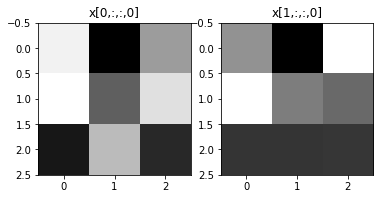

In [9]:
np.random.seed(1)

X_rand = np.random.randn(4, 3, 3, 2)
print ("X_rand.shape =", X_rand.shape)

print('Original Images')
plt.rcParams['figure.figsize'] = (6, 10)
fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x[0,:,:,0]')
axarr[0].imshow(X_rand[0,:,:,0])
axarr[1].set_title('x[1,:,:,0]')
axarr[1].imshow(X_rand[1,:,:,0])
plt.show()

Now give pad to images above with padding size=2

X_rand_pad.shape = (4, 7, 7, 2)
X_rand_pad[1,1] =
 [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]] 

Padded Images


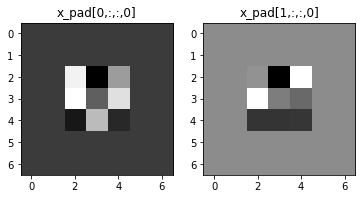

In [10]:
X_rand_pad = zero_pad(X_rand, 2)

print ("X_rand_pad.shape =", X_rand_pad.shape)
print ("X_rand_pad[1,1] =\n", X_rand_pad[1,1].T,'\n')

print('Padded Images')
fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x_pad[0,:,:,0]')
axarr[0].imshow(X_rand_pad[0,:,:,0])
axarr[1].set_title('x_pad[1,:,:,0]')
axarr[1].imshow(X_rand_pad[1,:,:,0])
plt.show()

---
## 2 - Single step of convolution 

In this part, implement **JUST A SINGLE STEP** of matrix multiplication in convolution process, in which you apply the filter to a single position of the input. 

<font color='red'>**WITHOUT THE CONVOLUTION LOOP**</font>

<br>

<center>
<img src="https://image.ibb.co/fv7f49/conv_step.png" width='600'>
</center>

Perform Element-wise product between $input\_slice$ and $W$. 
After that, Sum over all entries of volume $S$ and add bias $b$ to get the result

Later in this notebook, you'll apply this function to multiple positions of the input to implement the full convolutional operation. 

---

    Implement conv_single_step():
    * Perform Element-wise product between input_slice and W. 
    * Sum over all entries of volume S 
    * add bias to get the result

*Hint* : use `np.multiply()` and `np.sum()`

In [11]:
def conv_single_step(input_slice, W, b):
    """
    Apply one filter defined by parameters W on a single slice (input_slice) of the output activation 
    of the previous layer.
    
    Arguments:
    input_slice -- slice of input data of shape (f, f, C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1,)
    
    Returns:
    z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """
    
    # Element-wise product between input_slice and W. You can use np.multiply() 
    S = np.multiply(input_slice, W)
    
    # Sum over all entries of the volume S
    # Then Add bias. 
    z = np.sum(S) + b
    
    return z

In [12]:
np.random.seed(1)
X_slice = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn()

Z = conv_single_step(X_slice, W, b)
print("Z =", Z)

Z = -6.999089450680221


---
## 3 - Slicing Array

The `conv_single_step` function above will be used to calculate the activation of each slice of image when we convolve the filter.

<centeR>
<img src="https://stanford.edu/~shervine/images/convolution-layer-a.png" width="700">
</center>


To make things easier, we build  `get_slice()` function as follow

---

  * implement **get_slice()** function to slice a 3D array 
  * Slicing begin from vertical position **H_start** and horizontal position **W_start**
  * Resulting a **3D array** with height $H$ and width $W$ with the same depth as input

In [13]:
def get_slice(X, H_start, W_start, H, W):
    """
    Slicing X input in shape of f_size from postition H_start and W_start
    Input:
    - X       : Input data of shape (H, W, C)
    - H_start : height (vertical) position to begin the slicing
    - W_start : width (horizontal) position to begin the slicing
    - H       : height slice
    - W       : width slice
    
    Returns:
    - slices : a slice of data of shape (H, W, C)
    """
    slices = X[H_start:H_start+H, W_start:W_start+W,:]
    
    return slices

Check your implementations

* with an input of size $5\times5$ and a filter of size $3\times3$, 
* there will be $9$ slices across the space, 
* with each slice should be a $3\times3$ matrix (same size as filter)

<br>

Here we'll get **the first three slices**

In [14]:
np.random.seed(15)
X_int = np.random.randint(0,2,(5,5,1))
print('X_int =')
print('\n'.join(' '.join(str(cell) for cell in row) for row in X_int[:,:,0]))
print()


f_size = 3

slices00 = get_slice(X_int, 0, 0, f_size, f_size)

slices01 = get_slice(X_int, 0, 1, f_size, f_size)

slices10 = get_slice(X_int, 1, 0, f_size, f_size)

s = []
s1 = []
s00 = 'h = 0 ,w = 0\nshape ='+str(slices00.shape)+'\n'
s00 += '\n'.join(' '.join(str(cell) for cell in row) for row in slices00[:,:,0])
s00 += '\n-----------------\n'
s1.append(s00)

s01 = 'h = 0 ,w = 1\nshape ='+str(slices01.shape)+'\n'
s01 += '\n'.join(' '.join(str(cell) for cell in row) for row in slices01[:,:,0])
s01 += '\n-----------------\n'
s1.append(s01)
s.append(s1)

s2 = []
s10 = 'h = 1 ,w = 0\nshape ='+str(slices10.shape)+'\n'
s10 += '\n'.join(' '.join(str(cell) for cell in row) for row in slices10[:,:,0])
s10 += '\n-----------------\n'
s2.append(s10)
s.append(s2)

print(tabulate(s,tablefmt="pipe"))

X_int =
0 1 0 1 1
0 0 1 1 1
1 0 1 1 1
1 1 1 0 0
0 1 0 1 1

|:------------------|:------------------|
| h = 0 ,w = 0      | h = 0 ,w = 1      |
| shape =(3, 3, 1)  | shape =(3, 3, 1)  |
| 0 1 0             | 1 0 1             |
| 0 0 1             | 0 1 1             |
| 1 0 1             | 0 1 1             |
| ----------------- | ----------------- |
| h = 1 ,w = 0      |                   |
| shape =(3, 3, 1)  |                   |
| 0 0 1             |                   |
| 1 0 1             |                   |
| 1 1 1             |                   |
| ----------------- |                   |


---
## 4 - Stride

For a convolutional or a pooling operation, the stride $S$ denotes the number of pixels by which the window moves after each operation. 

Below is the example of slicing with **stride=**$2$
<center>
  <img src='https://stanford.edu/~shervine/images/stride.png' width=600><br>
  <img src='https://stanford.edu/~shervine/images/padding-valid-a.png' width=300></center>

---

### a. Slicing Stride=1
* with an input of size $5\times5$ and a filter of size $3\times3$, 
* if we slice with **stride=**$1$
* there will be $9$ slices across the space, 
* with each slice should be a $3\times3$ matrix (same size as filter)

<br>

Now, to do it automatically to slice all possible location, we can use for loop as follow:

In [15]:
f_size = 3
output_h = 3
output_w = 3

output = []

for h in range(output_h):
    
    w_out = []
    for w in range(output_w):
        
        slices = get_slice(X_int, h, w, f_size, f_size)
        
        s = 'h='+str(h)+', w='+str(w)+'\nshape='+str(slices.shape)+'\n'
        s += '\n'.join(' '.join(str(cell) for cell in row) for row in slices[:,:,0])
        s += '\n----------------'
        w_out.append(s)
        
    output.append(w_out)


    
s = '\n'.join(' '.join(str(cell) for cell in row) for row in X_int[:,:,0])
print('X_int =')
print(tabulate([[s]],tablefmt="pipe"))
print('\nslices =')
print(tabulate(output,tablefmt="pipe"))

X_int =
|:----------|
| 0 1 0 1 1 |
| 0 0 1 1 1 |
| 1 0 1 1 1 |
| 1 1 1 0 0 |
| 0 1 0 1 1 |

slices =
|:-----------------|:-----------------|:-----------------|
| h=0, w=0         | h=0, w=1         | h=0, w=2         |
| shape=(3, 3, 1)  | shape=(3, 3, 1)  | shape=(3, 3, 1)  |
| 0 1 0            | 1 0 1            | 0 1 1            |
| 0 0 1            | 0 1 1            | 1 1 1            |
| 1 0 1            | 0 1 1            | 1 1 1            |
| ---------------- | ---------------- | ---------------- |
| h=1, w=0         | h=1, w=1         | h=1, w=2         |
| shape=(3, 3, 1)  | shape=(3, 3, 1)  | shape=(3, 3, 1)  |
| 0 0 1            | 0 1 1            | 1 1 1            |
| 1 0 1            | 0 1 1            | 1 1 1            |
| 1 1 1            | 1 1 0            | 1 0 0            |
| ---------------- | ---------------- | ---------------- |
| h=2, w=0         | h=2, w=1         | h=2, w=2         |
| shape=(3, 3, 1)  | shape=(3, 3, 1)  | shape=(3, 3, 1)  |
| 1 0 1      

---
### b. Slicing Stride=2
* with an input of size $5\times5$ and a filter of size $3\times3$, 
* if we slice with **stride=**$2$
* there will be $4$ slices across the space, 
* with each slice should be a $3\times3$ matrix (same size as filter)

In [16]:
f_size = 3
stride = 2

output_h = 2
output_w = 2

output = []

for h in range(output_h):
    
    w_out = []
    for w in range(output_w):
        
        slices = get_slice(X_int, h*stride, w*stride, f_size, f_size)
        
        s = 'h='+str(h)+', w='+str(w)+'\nshape='+str(slices.shape)+'\n'
        s += '\n'.join(' '.join(str(cell) for cell in row) for row in slices[:,:,0])
        s += '\n----------------'
        w_out.append(s)
        
    output.append(w_out)


    
s = '\n'.join(' '.join(str(cell) for cell in row) for row in X_int[:,:,0])
print('X_int =')
print(tabulate([[s]],tablefmt="pipe"))
print('\nslices =')
print(tabulate(output,tablefmt="pipe"))

X_int =
|:----------|
| 0 1 0 1 1 |
| 0 0 1 1 1 |
| 1 0 1 1 1 |
| 1 1 1 0 0 |
| 0 1 0 1 1 |

slices =
|:-----------------|:-----------------|
| h=0, w=0         | h=0, w=1         |
| shape=(3, 3, 1)  | shape=(3, 3, 1)  |
| 0 1 0            | 0 1 1            |
| 0 0 1            | 1 1 1            |
| 1 0 1            | 1 1 1            |
| ---------------- | ---------------- |
| h=1, w=0         | h=1, w=1         |
| shape=(3, 3, 1)  | shape=(3, 3, 1)  |
| 1 0 1            | 1 1 1            |
| 1 1 1            | 1 0 0            |
| 0 1 0            | 0 1 1            |
| ---------------- | ---------------- |


---
## 5 - Convolution Naive Forward


The core of a convolutional network is the convolution operation. 

In the forward pass, you will 
* take many filters and convolve them on the input. 
* each '**convolution**' gives a 2D matrix output. 
*  then stack these outputs to get a 3D volume.

<center>
<img src="https://image.ibb.co/imSLj9/conv_kiank2.gif" width="800">
</center>


<br>

And from previous exercises, you should already figure it out the formula to calculate the output volume size 

given the input volume size, filter size, padding size, and stride

$$
\begin{align}
H_{out} &= 1+\frac{(H_{in}+2P-H_f)}{S}\\\\
W_{out} &= 1+\frac{(W_{in}+2P-W_f)}{S}\\\\
C_{out} &= F
\end{align}
 $$

---

**Implement the forward pass** for the convolution layer in the function `conv_forward_naive`. 

<br>

Note: 
<pre>You don't have to worry too much about efficiency at this point; 
just write the code in whatever way you find most clear.

In [17]:
def conv_forward_naive(X, W, b, conv_param):
    """
    A naive implementation of the forward pass for a convolutional layer.

    The input consists of N data points, each with height H_in, width W_in and C channels. 
    
    We convolve each input with F different filters, where each filter
    spans all C channels and has height H_f and width W_f.

    Input:
    - X: Input data of shape (N, H_in, W_in, C)
    - W: Filter weights of shape (F, H_f, W_f, C)
    - b: Biases, of shape (F,)
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input. 
        

    During padding, 'pad' zeros should be placed symmetrically (i.e equally on both sides)
    along the height and width axes of the input. Be careful not to modfiy the original
    input x directly.

    Returns a tuple of:
    - out: Output data, of shape (N, H_out, W_out, C_out) where H_out and W_out are given by
      H_out = 1 + (H_in + 2 * pad - H_f) / stride
      W_out = 1 + (W_in + 2 * pad - W_f) / stride
      C_out = number of filter (F)
    - cache: (X, W, b, conv_param)
    """
    out = None
    
    N, H_in, W_in, C = X.shape
    F, H_f, W_f, _ = W.shape
    
    P = conv_param["pad"]
    S = conv_param["stride"]

    # output (activation) size after convolution
    H_out = 1+((H_in+(2*P)-H_f)//S)
    W_out = 1+((W_in+(2*P)-W_f)//S)
    C_out = F
    
    # initialize output matrix
    out = np.zeros((N, H_out, W_out, C_out))

    # add P zero padding to input X by calling zero_pad function
    X_pad = zero_pad(X, P)

    # Convolution Forward Pass
    # loop for all data 
    for i in range(N):
        
        # get the i-th example from padded X_pad
        X_i = X_pad[i,:,:,:]

        # loop for all filter
        for f in range(F):            

            # loop in output height
            for h in range(H_out):

                #loop in output width
                for w in range(W_out):                
        
                    # get slice of X_i by calling get_slice function with the size of H_f and W_f
                    # Note: mind the stride!
                    X_slice = get_slice(X_i, h*S, w*S, H_f, W_f)
                    
                    # calculate the convolution output by calling conv_single_step function
                    # with input X_slice, W[f], and b[f]
                    out[i, h, w, f] = conv_single_step(X_slice, W[f], b[f])
                                        
    # Making sure your output shape is correct
    assert(out.shape == (N, H_out, W_out, C_out))
    
    cache = (X, W, b, conv_param)
    
    return out, cache

Check your implementations

In [18]:
np.random.seed(1)
X_rand = np.random.randn(10,4,4,3)
W = np.random.randn(8,2,2,3)
b = np.random.randn(8,)

conv_param = {"pad" : 2, "stride": 1}


Z, cache_conv = conv_forward_naive(X_rand, W, b, conv_param)
print("Z's mean =", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = 0.03749357578367075
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


In [19]:
np.random.seed(1)
X_rand = np.random.randn(10,4,4,3)
W = np.random.randn(8,2,2,3)
b = np.random.randn(8,)

conv_param = {"pad" : 3, "stride": 2}


Z, cache_conv = conv_forward_naive(X_rand, W, b, conv_param)
print("Z's mean =", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = 0.003582574977755886
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


---
## 6 - Remove Pad

Since normally we use pad to $X$ berfore we convolve it with filters, thus the backward propagate will result $dX$ with size of padded $X$. 

As a helper function, we need a function to remove the pad from $dX$ so it can be the same size as $X$


**Remove padding from X**

In this excercise, X is a 4-dimensional array, and we want to remove the pad in the 2nd and 3rd dimension

*Hint*: the idea is the same as slicing

In [20]:
def remove_pad(X_pad, pad):    
    """
    Remove the padding that is applied to the height and width of X
    
    Argument:
    X_pad -- python numpy array of shape (m, H_n, W_n, C_n) representing a batch of m images
    pad -- integer, amount of padding to remove from around each image on vertical and horizontal dimensions
    
    Returns:
    X --  image of shape (m, H_n - 2*pad, W_n - 2*pad, C_n)
    """
    X = X_pad[:, pad:-pad, pad:-pad, :]
    
    return X

Check your implementations

In [21]:
np.random.seed(1)

x = np.random.randn(4, 3, 3, 2)
print ("x.shape         =", x.shape)

x_pad = zero_pad(x, 2)
print ("x_pad.shape     =", x_pad.shape)

x_removed = remove_pad(x_pad,2)
print ("x_removed.shape =", x_removed.shape)

x.shape         = (4, 3, 3, 2)
x_pad.shape     = (4, 7, 7, 2)
x_removed.shape = (4, 3, 3, 2)


original images


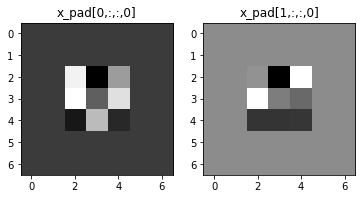


removed pad images


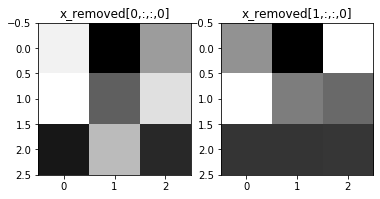

In [22]:
print('original images')
plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x_pad[0,:,:,0]')
axarr[0].imshow(x_pad[0,:,:,0])
axarr[1].set_title('x_pad[1,:,:,0]')
axarr[1].imshow(x_pad[1,:,:,0])
plt.show()

print('\nremoved pad images')
fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x_removed[0,:,:,0]')
axarr[0].imshow(x_removed[0,:,:,0])
axarr[1].set_title('x_removed[1,:,:,0]')
axarr[1].imshow(x_removed[1,:,:,0])
plt.show()

---
## 7 - Convolution Naive Backward

In modern deep learning frameworks, you only have to implement the forward pass, and the framework takes care of the backward pass, so most deep learning engineers don't need to bother with the details of the backward pass. 

The backward pass for convolutional networks is complicated, but we'll try to implement the backward pass step by step


---
### a. Convolution Backward Math

Now remember that in convolutional layer, the backward pass is also a convolution process. 

<center>
  <img src='https://image.ibb.co/mkvjCU/backward.png' width=400>
</center>

First, let's take a look at the math


As the normal Neural Net layer, there are three (3) steps to make in Backward pass:
* Computing $\partial X$
* Computing $\partial W$, and 
* Computing $\partial b$

Now let's take a look on how to implement those

---
#### Computing $\partial X$:
This is the formula for computing $\partial A$ with respect to the cost for a certain filter $W_c$ and a given training example:

$$ dX += \sum _{h=0} ^{n\_H} \sum_{w=0} ^{n\_W} W_f \times dout_{hw} \tag{1}$$

* Where $W_f$ is a filter and $dout_{hw}$ is a scalar corresponding to the gradient of the cost with respect to the output of the conv current layer at the $h$-th row and $w$-th column 
* (corresponding to the dot product taken at the $i$-th stride left and $j$-th stride down). 

<br>

Note that at each time, we multiply the the same filter $W_f$ by a different $dout$ when updating $dX$. We do so mainly because when computing the forward propagation, each filter is dotted and summed by a different $X_{slices}$. 

Therefore when computing the backprop for $dX$, we are just adding the gradients of all the $X_{slices}$. 

<br>

In code, inside the appropriate for-loops, this formula translates into:

```python
dX[h_start:h_end, w_start:w_end, :] += W[f,:,:,:] * dout[i, h, w, f]
```

---

#### Computing $\partial W$:
This is the formula for computing $dW_f$ with respect to the loss:

$$ dW_f  += \sum _{h=0} ^{n\_H} \sum_{w=0} ^ {n\_W} X_{slice} \times dout_{hw}  \tag{2}$$

* ($dW_f$ is the derivative of one filter)

<br>

Where $X_{slice}$ corresponds to the slice which was used to generate the acitivation $out_{ij}$. 

Hence, this end up giving us the gradient for $W$ with respect to that slice. 

Since it is the same $W$, we will just add up all such gradients to get $dW$. 

<br>

In code, inside the appropriate for-loops, this formula translates into:
```python
dW[f,:,:,:] += X_slice * dout[i, h, w, f]
```

---
#### Computing $\partial b$:

This is the formula for computing $db$ with respect to the cost for a certain filter $W_c$:

$$ db = \sum_h \sum_w dout_{hw} \tag{3}$$

As you have previously seen in basic neural networks, db is computed by summing $dout$. In this case, you are just summing over all the gradients of the current conv output with respect to the cost. 

<br>

In code, inside the appropriate for-loops, this formula translates into:
```python
db[f,:,:,:] += dout[i, h, w, f]
```

---
### b - Convolution Backward Naive Function

After all helper functions are made, we can implement the naive backward pass for convolution layer in the function conv_backward_naive

In [23]:
def conv_backward_naive(dout, cache):
    """
    A naive implementation of the backward pass for a convolutional layer.

    Inputs:
    - dout: Upstream derivatives.
    - cache: A tuple of (x, w, b, conv_param) as in conv_forward_naive

    Returns a tuple of:
    - dx: Gradient with respect to x
    - dw: Gradient with respect to w
    - db: Gradient with respect to b
    """
    
    dX, dW, db = None, None, None
    
    X, W, b, conv_param = cache

    N, H_out, W_out, F = dout.shape
    N, H_in,  W_in,  C = X.shape
    F, H_f,   W_f,   C = W.shape
    P = conv_param["pad"]
    S = conv_param["stride"]

    
    # add P zero padding to input X by calling zero_pad function
    X_pad = zero_pad(X, P)

    # initialize dX with zeros matrix of size = X_pad
    dX = np.zeros(X_pad.shape)  
    # initialize dW with zeros matrix of size = W
    dW = np.zeros(W.shape)   
    # initialize db with zeros matrix of size = b
    db = np.zeros(b.shape) 
        
    ## ------------------------- start your code here -------------------------
    
    # Convolution Backward Pass
    # loop for all data 
    for i in range(N):
        
        # select the i-th example from X_pad
        X_i = X_pad[i,:,:,:]
        
        # select the i-th gradient from dX
        dX_i = dX[i,:,:,:]
        
        # loop for all filter
        for f in range(F):            
            
            # loop in output height
            for h in range(H_out):
                
                #loop in output width
                for w in range(W_out):
                    
                    # get slice of X_i by calling get_slice function with the size of H_f and W_f
                    # Note: mind the stride!
                    X_slice = get_slice(X_i, h*S, w*S, H_f, W_f)
                    
                    # get slice of dX_i by calling get_slice function with the size of H_f and W_f
                    # Note: mind the stride!
                    dX_slice = get_slice(dX_i, h*S, w*S, H_f, W_f)
                    
                    # update the value of gradient dX_slice by adding the result from W[f] * dout[i, h, w, f]
                    dX_slice += W[f]*dout[i, h, w, f]
                    
                    # update the value of gradient dW[f] by adding the result from X_slice * dout[i, h, w, f]
                    dW[f] += X_slice*dout[i, h, w, f]
                    
                    # update the value of gradient db[f] by adding dout[i, h, w, f] to it
                    db[f] += dout[i, h, w, f]
    
    # remove the pad in dX by calling remove_pad with size of P
    dX = remove_pad(dX, P)
    
    
    ## ------------------------- your code end here ---------------------------
    
    # Making sure your output shape is correct
    assert(dX.shape == (N, H_in, W_in, C))
    
    return dX, dW, db

In [24]:
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(8,2,2,3)
b = np.random.randn(8,)
conv_param = {"pad" : 2, "stride": 1}

Z, cache_conv = conv_forward_naive(A_prev, W, b, conv_param)
print("Z's mean               =", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])
print()

dX, dW, db = conv_backward_naive(Z, cache_conv)
print("dX_mean =", np.mean(dX))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

Z's mean               = 0.03749357578367075
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]

dX_mean = 7.60493719340998
dW_mean = 9.271277763672389
db_mean = 18.371852133998935


---
## 8 - Image processing via convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (**grayscale conversion** and **edge detection**).

The convolution forward pass will apply these operations to each of the input images.

We can then visualize the results as a sanity check.

In [25]:
from imageio import imread
from skimage.transform import resize


def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

In [26]:
kitten, puppy = imread('assets/kitten.jpg'), imread('assets/puppy.jpg')

---
### b. View Images

Now show the two cute images

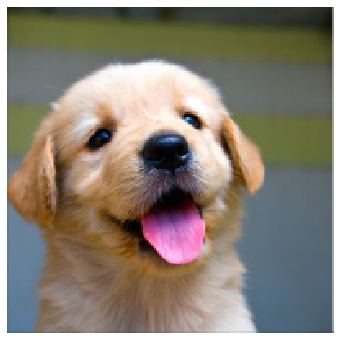

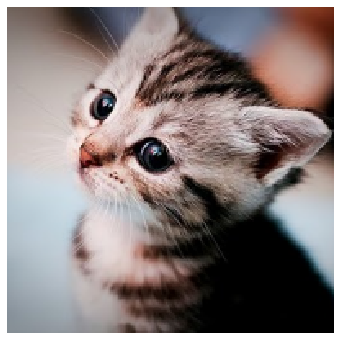

In [27]:
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]


img_size = 200   # Make this smaller if it runs too slow


X_image = np.zeros((2, img_size, img_size, 3))
X_image[0, :, :, :] = resize(puppy, (img_size, img_size), mode='constant')
X_image[1, :, :, :] = resize(kitten_cropped, (img_size, img_size), mode='constant')

plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
imshow_noax(X_image[0, :, :, :])
plt.show()
imshow_noax(X_image[1, :, :, :])
plt.show()

---
### c. Grayscale Filter

Set up a convolutional weights holding 2 filters, each 3x3

The first filter converts the image to grayscale. Set up the red, green, and blue channels of the filter

In [28]:
W_image = np.zeros((2, 3, 3, 3))

W_image[0, :, :, 0] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
W_image[0, :, :, 1] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
W_image[0, :, :, 2] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

---
### d. Edge Detection Filter

Second filter detects horizontal edges in the blue channel.

For Edge Detection filter, we need to add 128 to each output so that nothing is negative. So we create a Vector of biases

In [29]:
W_image[1, :, :, 2] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

b_image = np.array([0, 128])

---
### e. Process Convolution

Compute the result of convolving each input in **X_image** with each filter in **W_image**, offsetting by **b_image**, and storing the results in $out$.

In [30]:
out, _ = conv_forward_naive(X_image, W_image, b_image, {'stride': 1, 'pad': 1})

---
### f. View Results
Let's take a look at the greyscale and edge detection results

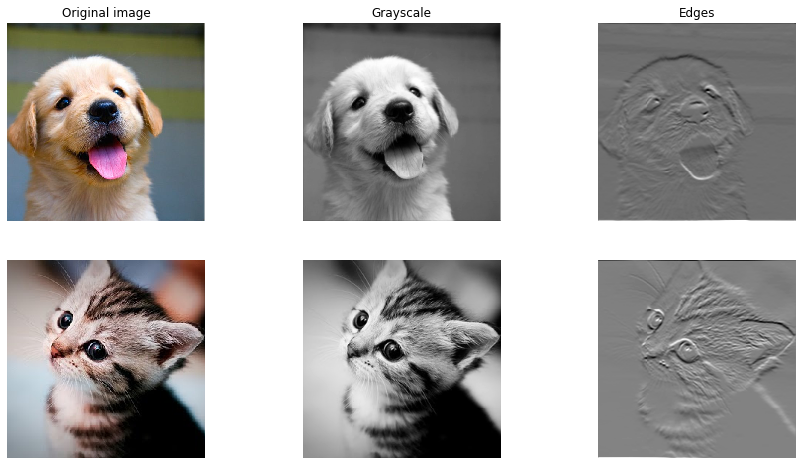

In [31]:
plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default size of plots
# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, :, :, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, :, :, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, :, :, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, :, :, 1])
plt.show()

---
---
# [Part 2] Pooling Layer

The pooling (POOL) layer reduces the height and width of the input. It helps reduce computation, as well as helps make feature detectors more invariant to its position in the input. The two types of pooling layers are: 

- Max-pooling layer: slides an ($f, f$) window over the input and stores the max value of the window in the output.

- Average-pooling layer: slides an ($f, f$) window over the input and stores the average value of the window in the output.

<p align='center'>
<table>
<td>
<img src="https://image.ibb.co/dfLq5e/max_pool1.png" width=500>
<td>

<td>
<img src="https://image.ibb.co/hegmdz/a_pool.png" width=500>
<td>
</table>
</p>

<br>

These pooling layers have no parameters for backpropagation to train. However, they have hyperparameters such as the window size $f$. 
This specifies the height and width of the $[f\times f]$ window you would compute a **max** or **average** over. 

Now, you are going to implement **MAX-POOL** and **AVG-POOL**, in the same function. 

---
## 1 - Pooling Naive Forward

As there's no padding, the formulas binding the output shape of the pooling to the input shape is:


$$
\begin{align}
H_{out} &= \lfloor \frac{H_{in} - H_f}{S} \rfloor +1\\\\
W_{out} &= \lfloor \frac{W_{in} - W_f}{S} \rfloor +1\\\\
C_{out} &= C_{in}
\end{align}
 $$

In [32]:
def pool_forward_naive(X, pool_param, mode='max'):
    """
    A naive implementation of the forward pass for a max-pooling layer.

    Inputs:
    - X: Input data, of shape (N, H_in, W_in, C)
    - pool_param: dictionary with the following keys:
      - 'pool_height': The height of each pooling region
      - 'pool_width': The width of each pooling region
      - 'stride': The distance between adjacent pooling regions
    - mode: the pooling mode you would like to use, defined as a string ("max" or "avg")

    No padding is necessary here. Output size is given by 

    Returns a tuple of:
    - out: Output data, of shape (N, H_out, W_out, C) where H_out and W_out are given by
      H_out = 1 + (H_in - pool_height) / stride
      W_out = 1 + (W_in - pool_width) / stride
    - cache: (X, pool_param)
    """
    
    out = None
    
    N, H_in, W_in, C = X.shape
    
    pool_height = pool_param['pool_height']
    pool_width = pool_param['pool_width']
    stride = pool_param['stride']
    
    
    ## ------------------------- start your code here -------------------------
    
    # Define the dimensions of the output
    H_out = 1+((H_in-pool_height)//stride)
    W_out = 1+((W_in-pool_width)//stride)

    # initialize zeros matrix for output with the specified dimension
    out = np.zeros([N, H_out, W_out, C]) 
    
    # Pooling Forward Pass
    # loop for all data 
    for i in range(N):         
            
        # loop in output height
        for h in range(H_out):

            #loop in output width
            for w in range(W_out):
                
                # loop for all Channel
                for c in range(C):           
                    
                    # get slice of X[i] by calling get_slice function with the size of pool_height and pool_width
                    # Note: mind the stride!
                    X_slice = get_slice(X[i], h*stride, w*stride, pool_height, pool_width)
                    
                    # Compute the pooling operation on the c-th slice. 
                    # Use an if statment to differentiate the modes. 
                    # Use np.max or np.mean to X_slice[:,:,c]
                    
                    if mode == "max":
                        out[i, h, w, c] = np.max(X_slice[:,:,c])
                    elif mode == "avg":
                        out[i, h, w, c] = np.mean(X_slice[:,:,c])
                        
                        
    ## ------------------------- your code end here ---------------------------

    
    # Making sure your output shape is correct
    assert(out.shape == (N, H_out, W_out, C))
    
    # Store the input and pool_param in "cache" for pool_backward()
    cache = (X, pool_param)
    
    return out, cache

In [33]:
np.random.seed(48)
A_prev = np.random.randint(0, 10,(2, 4, 4, 3))
pool_param = {'pool_width': 4, 'pool_height': 4, 'stride': 1}

print('Input activation A_prev =')
print(tabulate(A_prev.transpose(0,1,3,2)[0],tablefmt="pipe"))
print(tabulate(A_prev.transpose(0,1,3,2)[1],tablefmt="pipe"))
print()

A, cache = pool_forward_naive(A_prev, pool_param)
print('mode = max pool')
print('pool shape =',A.shape)
print(tabulate(A.reshape(2,3),tablefmt="pipe"))
print()

A, cache = pool_forward_naive(A_prev, pool_param, mode = 'avg')
print('mode = average pool')
print('pool shape =',A.shape)
print(tabulate(A.reshape(2,3),tablefmt="pipe"))

Input activation A_prev =
|:----------|:----------|:----------|
| [0 4 6 0] | [3 0 6 6] | [1 0 2 6] |
| [0 2 2 2] | [7 2 5 6] | [8 5 9 2] |
| [1 0 6 6] | [5 5 6 2] | [6 2 5 2] |
| [5 3 3 0] | [4 2 3 2] | [7 0 6 1] |
|:----------|:----------|:----------|
| [6 9 4 6] | [9 1 2 3] | [3 7 1 5] |
| [0 2 3 0] | [7 1 0 7] | [4 9 3 4] |
| [0 1 5 9] | [3 0 5 2] | [3 6 9 0] |
| [8 6 0 5] | [8 7 0 1] | [5 6 3 6] |

mode = max pool
pool shape = (2, 1, 1, 3)
|--:|--:|--:|
| 6 | 7 | 9 |
| 9 | 9 | 9 |

mode = average pool
pool shape = (2, 1, 1, 3)
|----:|----:|------:|
| 2.5 | 4   | 3.875 |
| 4   | 3.5 | 4.625 |


---
## 2 - Pooling Naive Backward


Next, let's implement the backward pass for the pooling layer, starting with the **MAX-POOL** layer. 

Even though a pooling layer has no parameters for backprop to update, you still need to propagate back the gradient through the pooling layer in order to compute gradients for layers that came before the pooling layer. 

---
### a. MaxPool: Mask Function

Before jumping into the backpropagation of the pooling layer, you are going to build a helper function called `create_mask_from_window()` which does the following: 

$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}$$

<br>

As you can see, this function creates a **"mask"** matrix which keeps track of where the maximum of the matrix is. 

* True (1) indicates the position of the maximum in X, 
* the other entries are False (0). 

<br>


Why do we keep track of the position of the max? 

It's because this is the input value that ultimately influenced the output, and therefore the cost. Backprop is computing gradients with respect to the cost, so anything that influences the ultimate cost should have a non-zero gradient. 

<p align='center'>
<img src='https://image.ibb.co/jYWpe9/maxpool.png'>
</p>

So, backprop will "propagate" the gradient back to this particular input value that had influenced the cost. 

<br>


You'll see later that the backward pass for average pooling will be similar to this but using a different mask.  

Implement `create_mask_from_window()`. 


Hints:
- [np.max()]() may be helpful. It computes the maximum of an array.
- If you have a matrix X and a scalar x: `A = (X == x)` will return a matrix A of the same size as X such that:
```
A[i,j] = True if X[i,j]   = x
A[i,j] = False if X[i,j] != x
```
- Here, you don't need to consider cases where there are several maxima in a matrix.

In [34]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    
    Arguments:
    x -- Array of shape (f, f)
    
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """
    
    mask = (x == np.max(x))
    
    return mask

In [35]:
np.random.seed(1)
x = np.random.randint(0,10,(2,3))

mask = create_mask_from_window(x)
print('x =')
print(x)

print('\nmax x = ', np.max(x),'\n')

print('mask =')
print(mask)

x =
[[5 8 9]
 [5 0 0]]

max x =  9 

mask =
[[False False  True]
 [False False False]]


---
### b. AvgPool: Distribute Function

In max pooling, for each input window, all the "influence" on the output came from a single input value--the max. 

In average pooling, every element of the input window has equal influence on the output. So to implement backprop, you will now implement a helper function that reflects this.

For example if we did average pooling in the forward pass using a 2x2 filter, then the mask you'll use for the backward pass will look like: 
$$ dX = 1 \quad \rightarrow  \quad dX =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

This implies that each position in the $dX$ matrix contributes equally to output because in the forward pass, we took an average. 

<p align='center'><img src='https://image.ibb.co/mYj6sU/avgpool.png'></p>

In [36]:
def distribute_value(dout, shape):
    """
    Distributes the input value in the matrix of dimension shape
    
    Arguments:
    dout -- input scalar, Upstream derivatives
    shape -- the shape (H_out, W_out) of the output matrix for which we want to distribute the value of dout
    
    Returns:
    a -- Array of size (H_out, W_out) for which we distributed the value of dout
    """
    
    # Retrieve dimensions from shape (≈1 line)
    (H_out, W_out) = shape
    
    # Compute the value to distribute on the matrix (≈1 line)
    average = H_out*W_out
    
    # Create a matrix where every entry is the "average" value (≈1 line)
    # use np.ones
    a = (np.ones(shape)*dout)/average
    
    return a

In [37]:
dout = 2
print('dout =', dout)

shape = (2,2)
a = distribute_value(dout, shape)
print('distributed value =')
print(a)

dout = 2
distributed value =
[[0.5 0.5]
 [0.5 0.5]]


---
### c. Pooling Backward Function

You now have everything you need to compute backward propagation on a pooling layer.

Implement the **pool_backward()** function in both modes (`'max'` and `'avg'`). 

* You will once again use **4 for-loops** (iterating over training examples, height, width, and channels). 

* You should use an `if/elif` statement to see if the mode is equal to `'max'` or `'avg'`. 
* If it is equal to `'average'` you should use the `distribute_value()` function you implemented above to create a matrix of the same shape as `a_slice`. 
* Otherwise, the mode is equal to `'max'`, and you will create a mask with `create_mask_from_window()` and multiply it by the corresponding value of dout.

In [38]:
def pool_backward_naive(dout, cache, mode = 'max'):
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
    dout -- gradient of cost with respect to the output of the pooling layer, same shape as X
    cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
    mode -- the pooling mode you would like to use, defined as a string ("max" or "avg")
    
    Returns:
    dX -- gradient of cost with respect to the input of the pooling layer, same shape as X
    """
    
    ### START CODE HERE ###
    
    # Retrieve information from cache (≈1 line)
    (X, pool_param) = cache
    
    # Retrieve hyperparameters from "pool_param" (≈2 lines)
    pool_height = pool_param['pool_height']
    pool_width = pool_param['pool_width']
    stride = pool_param['stride']
    
    # Retrieve dimensions from X's shape and dout's shape (≈2 lines)
    N, H_in, W_in, C = X.shape
    N, H_out, W_out, C = dout.shape
    
    # Initialize dA_prev with zeros with the same size as X
    dX = np.zeros_like(X)
    
    
    ## ------------------------- start your code here -------------------------
    
    # loop over the training examples
    for i in range(N):                       
        
        # select i-th training example from X
        X_i = X[i,:,:,:]
        
        # select the i-th gradient from dX
        dX_i = dX[i,:,:,:]
        
        # loop in out height
        for h in range(H_out):
            
            # loop in out width
            for w in range(W_out):
                
                # loop for all Channel
                for c in range(C):                    
                    
                    # get slice of X[i] by calling get_slice function with the size of pool_height and pool_width
                    # Note: mind the stride!
                    X_slice = get_slice(X[i], h*stride, w*stride, pool_height, pool_width)

                    # get slice of dX_i by calling get_slice function with the size of pool_height and pool_width
                    # REMEMBER: mind the stride!
                    dX_slice = get_slice(dX[i], h*stride, w*stride, pool_height, pool_width)
                    
                    
                    # Compute the backward propagation in both modes.
                    if mode == 'max':
                        
                        # Create the mask from X_slice[:,:,c] window by calling create_mask_from_window
                        mask = create_mask_from_window(X_slice[:,:,c])
                                                
                        # update dX_slice[:,:,c] by adding the result of mask * dout[i,h,w,c]
                        dX_slice[:,:,c] += mask*dout[i, h, w, c]

                    elif mode == 'avg':                  
                        
                        # Get the value dx from dout[i, h, w, c]
                        dx = dout[i, h, w, c]
                        
                        # Define the shape of the filter as [pool_height x pool_width] (≈1 line)
                        shape = (pool_height, pool_width)
                                                
                        # update dX_slice[:,:,c] by adding the result of the distributed value of dx 
                        # by calling distribute_value winth input dX and shape
                        dX_slice[:,:,c] += distribute_value(dx, shape)
                        
                        
    ## ------------------------- your code end here ----------------------------

    # Making sure your output shape is correct
    assert(dX.shape == X.shape)
    
    return dX

In [39]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 1}
A, cache = pool_forward_naive(A_prev, pool_param)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward_naive(dA, cache, mode = 'max')
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] =') 
print(dA_prev[1,1]) 
print()

dA_prev = pool_backward_naive(dA, cache, mode ='avg')
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] =') 
print(dA_prev[1,1]) 

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =
[[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =
[[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]


---
---
# [Part 3] Fast Layer API

Making convolution and pooling layers fast can be challenging. 

To spare you the pain, we've provided **fast implementations** of the forward and backward passes for convolution and pooling layers in the file `fast_layers.py`

In [40]:
# %load fast_layers.py
import numpy as np


def get_im2col_indices(x_shape, field_height, field_width, padding=1, stride=1):
	# First figure out what the size of the output should be
	N, C, H, W = x_shape
	assert (H + 2 * padding - field_height) % stride == 0
	assert (W + 2 * padding - field_height) % stride == 0
	out_height = int((H + 2 * padding - field_height) // stride + 1)
	out_width = int((W + 2 * padding - field_width) // stride + 1)

	i0 = np.repeat(np.arange(field_height), field_width)
	i0 = np.tile(i0, C)
	i1 = stride * np.repeat(np.arange(out_height), out_width)
	j0 = np.tile(np.arange(field_width), field_height * C)
	j1 = stride * np.tile(np.arange(out_width), out_height)
	i = i0.reshape(-1, 1) + i1.reshape(1, -1)
	j = j0.reshape(-1, 1) + j1.reshape(1, -1)

	k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

	return (k.astype(int), i.astype(int), j.astype(int))


def im2col_indices(x, field_height, field_width, padding=1, stride=1):
	""" An implementation of im2col based on some fancy indexing """
	# Zero-pad the input
	p = padding
	x_padded = np.pad(x, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant')

	k, i, j = get_im2col_indices(x.shape, field_height, field_width, padding, stride)

	cols = x_padded[:, k, i, j]
	C = x.shape[1]
	cols = cols.transpose(1, 2, 0).reshape(field_height * field_width * C, -1)
	return cols


def col2im_indices(cols, x_shape, field_height=3, field_width=3, padding=1,
				   stride=1):
	""" An implementation of col2im based on fancy indexing and np.add.at """
	N, C, H, W = x_shape
	H_padded, W_padded = H + 2 * padding, W + 2 * padding
	x_padded = np.zeros((N, C, H_padded, W_padded), dtype=cols.dtype)
	k, i, j = get_im2col_indices(x_shape, field_height, field_width, padding, stride)
	cols_reshaped = cols.reshape(C * field_height * field_width, -1, N)
	cols_reshaped = cols_reshaped.transpose(2, 0, 1)
	np.add.at(x_padded, (slice(None), k, i, j), cols_reshaped)
	if padding == 0:
		return x_padded
	return x_padded[:, :, padding:-padding, padding:-padding]


def conv_forward_fast(X, W, b, conv_param):
	X = np.transpose(X,(0,3,1,2))
	W = np.transpose(W,(0,3,1,2))
	#b2 = np.array([b]).T
	b2 = b[None].T
	padding = conv_param["pad"]
	stride = conv_param["stride"]
	
	n_filters, d_filter, h_filter, w_filter = W.shape
	n_x, d_x, h_x, w_x = X.shape
	h_out = (h_x - h_filter + 2 * padding) / stride + 1
	w_out = (w_x - w_filter + 2 * padding) / stride + 1

	if not h_out.is_integer() or not w_out.is_integer():
		raise Exception('Invalid output dimension!')

	h_out, w_out = int(h_out), int(w_out)

	X_col = im2col_indices(X, h_filter, w_filter, padding=padding, stride=stride)
	W_col = W.reshape(n_filters, -1)

	out = W_col @ X_col + b2
	out = out.reshape(n_filters, h_out, w_out, n_x)
	out = out.transpose(3, 0, 1, 2)

	X = np.transpose(X,(0,2,3,1))
	W = np.transpose(W,(0,2,3,1))
	out = np.transpose(out,(0,2,3,1))
	cache = (X, W, b, conv_param, X_col)
	return out, cache


def conv_backward_fast(dout, cache):
	X, W, b, conv_param, X_col = cache
	X = np.transpose(X,(0,3,1,2))
	W = np.transpose(W,(0,3,1,2))
	dout = np.transpose(dout,(0,3,1,2))
	n_filter, d_filter, h_filter, w_filter = W.shape

	padding = conv_param["pad"]
	stride = conv_param["stride"]

	db = np.sum(dout, axis=(0, 2, 3))
	db = db.reshape(n_filter, -1)

	dout_reshaped = dout.transpose(1, 2, 3, 0).reshape(n_filter, -1)
	dW = dout_reshaped @ X_col.T
	dW = dW.reshape(W.shape)

	W_reshape = W.reshape(n_filter, -1)
	dX_col = W_reshape.T @ dout_reshaped
	dX = col2im_indices(dX_col, X.shape, h_filter, w_filter, padding=padding, stride=stride)

	dX = np.transpose(dX,(0,2,3,1))
	dW = np.transpose(dW,(0,2,3,1))
	db = db.T[0]
	return dX, dW, db


def pool_forward_fast(X, pool_param, mode='max'):
	def maxpool(X_col):
		max_idx = np.argmax(X_col, axis=0)
		out = X_col[max_idx, range(max_idx.size)]
		return out, max_idx
		
	def avgpool(X_col):
		out = np.mean(X_col, axis=0)
		cache = None
		return out, cache
		
	if mode == 'max':
		return _pool_forward_fast(X, maxpool, pool_param)
	elif mode == 'avg':
		return _pool_forward_fast(X, avgpool, pool_param)
	
	
def pool_backward_fast(dout, cache, mode = 'max'):
	def dmaxpool(dX_col, dout_col, pool_cache):
		dX_col[pool_cache, range(dout_col.size)] = dout_col
		return dX_col
		
	def davgpool(dX_col, dout_col, pool_cache):
		dX_col[:, range(dout_col.size)] = 1. / dX_col.shape[0] * dout_col
		return dX_col

	if mode == 'max':
		return _pool_backward_fast(dout, dmaxpool, cache)
	elif mode == 'avg':
		return _pool_backward_fast(dout, davgpool, cache)
	

	
def _pool_forward_fast(X, pool_fun, pool_param):

	X = np.transpose(X,(0,3,1,2))
	
	pool_height = pool_param['pool_height']
	pool_width = pool_param['pool_width']
	stride = pool_param['stride']	
	
	
	n, d, h, w = X.shape
	h_out = (h - pool_height) / stride + 1
	w_out = (w - pool_width) / stride + 1

	if not w_out.is_integer() or not h_out.is_integer():
		raise Exception('Invalid output dimension!')

	h_out, w_out = int(h_out), int(w_out)

	X_reshaped = X.reshape(n * d, 1, h, w)
	X_col = im2col_indices(X_reshaped, pool_height, pool_width, padding=0, stride=stride)

	out, pool_cache = pool_fun(X_col)

	out = out.reshape(h_out, w_out, n, d)
	#out = out.transpose(2, 3, 0, 1)

	X = np.transpose(X,(0,2,3,1))
	out = out.transpose(2,0,1,3)
	cache = (X, pool_param, X_col, pool_cache)

	return out, cache


def _pool_backward_fast(dout, dpool_fun, cache):
	X, pool_param, X_col, pool_cache = cache
	
	pool_height = pool_param['pool_height']
	pool_width = pool_param['pool_width']
	stride = pool_param['stride']
	
	X = np.transpose(X,(0,3,1,2))
	dout = np.transpose(dout,(0,3,1,2))
	
	n, d, w, h = X.shape

	dX_col = np.zeros_like(X_col)
	dout_col = dout.transpose(2, 3, 0, 1).ravel()

	dX = dpool_fun(dX_col, dout_col, pool_cache)

	dX = col2im_indices(dX_col, (n * d, 1, h, w), pool_height, pool_width, padding=0, stride=stride)
	dX = dX.reshape(X.shape)
	
	dX = np.transpose(dX,(0,2,3,1))
	
	return dX

In [41]:
from time import time

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

np.random.seed(1)
X_big = np.random.randn(100, 31, 31, 3)
W_big = np.random.randn(25, 3, 3, 3)
b_big = np.random.randn(25,)
dout_big = np.random.randn(100, 16, 16, 25)
conv_param = {'stride': 2, 'pad': 1}

---
## 1 - Fast Convolution Layer

Now let's compare the naive version of Convolution layer with the fast implementation

In [42]:
t0 = time()
Z_naive, cache_conv_naive = conv_forward_naive(X_big, W_big, b_big, conv_param)
t1 = time()
Z_fast, cache_conv_fast = conv_forward_fast(X_big, W_big, b_big, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive     : %f seconds' % (t1 - t0))
print('Fast      : %f seconds' % (t2 - t1))
print('Speedup   : %fx faster' % ((t1 - t0) / (t2 - t1)))
print('Difference:', rel_error(Z_naive, Z_fast))

Testing conv_forward_fast:
Naive     : 3.895204 seconds
Fast      : 0.014908 seconds
Speedup   : 261.281469x faster
Difference: 6.517857670095003e-10


In [43]:
t0 = time()
dX_naive, dW_naive, db_naive = conv_backward_naive(dout_big, cache_conv_naive)
t1 = time()
dX_fast, dW_fast, db_fast = conv_backward_fast(dout_big, cache_conv_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive        : %f seconds' % (t1 - t0))
print('Fast         : %f seconds' % (t2 - t1))
print('Speedup      : %fx faster' % ((t1 - t0) / (t2 - t1)))
print('dx difference:', rel_error(dX_naive, dX_fast))
print('dw difference:', rel_error(dW_naive, dW_fast))
print('db difference:', rel_error(db_naive, db_fast))


Testing conv_backward_fast:
Naive        : 6.574766 seconds
Fast         : 0.065324 seconds
Speedup      : 100.648449x faster
dx difference: 4.663506492096179e-12
dw difference: 9.654576724931323e-13
db difference: 0.0


---
## 2 - Fast Pooling Layer

In [44]:
# Relative errors should be close to 0.0

np.random.seed(231)
X_big2 = np.random.randn(100, 32, 32, 3)
dout_big2 = np.random.randn(100, 16, 16, 3)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = pool_forward_naive(X_big2, pool_param)
t1 = time()
out_fast, cache_fast = pool_forward_fast(X_big2, pool_param)
t2 = time()

print('Testing max pool_forward_fast:')
print('Naive     : %f seconds' % (t1 - t0))
print('fast      : %f seconds' % (t2 - t1))
print('speedup   : %fx faster' % ((t1 - t0) / (t2 - t1)))
print('difference:', rel_error(out_naive, out_fast))

Testing max pool_forward_fast:
Naive     : 0.369821 seconds
fast      : 0.020219 seconds
speedup   : 18.290451x faster
difference: 0.0


In [45]:

t0 = time()
dX_naive = pool_backward_naive(dout_big2, cache_naive)
t1 = time()
dX_fast = pool_backward_fast(dout_big2, cache_fast)
t2 = time()

print('\nTesting max pool_backward_fast:')
print('Naive        : %f seconds' % (t1 - t0))
print('Fast         : %f seconds' % (t2 - t1))
print('Speedup      : %fx faster' % ((t1 - t0) / (t2 - t1)))
print('dx difference:', rel_error(dX_naive, dX_fast))


Testing max pool_backward_fast:
Naive        : 1.283423 seconds
Fast         : 0.036443 seconds
Speedup      : 35.217037x faster
dx difference: 0.0


In [46]:
t0 = time()
out_naive, cache_naive = pool_forward_naive(X_big2, pool_param, mode='avg')
t1 = time()
out_fast, cache_fast = pool_forward_fast(X_big2, pool_param, mode='avg')
t2 = time()

print('Testing avg pool_forward_fast:')
print('Naive     : %f seconds' % (t1 - t0))
print('fast      : %f seconds' % (t2 - t1))
print('speedup   : %fx faster' % ((t1 - t0) / (t2 - t1)))
print('difference:', rel_error(out_naive, out_fast))


t0 = time()
dX_naive = pool_backward_naive(dout_big2, cache_naive, mode='avg')
t1 = time()
dX_fast = pool_backward_fast(dout_big2, cache_fast, mode='avg')
t2 = time()

print('\nTesting avg pool_backward_fast:')
print('Naive        : %f seconds' % (t1 - t0))
print('Fast         : %f seconds' % (t2 - t1))
print('Speedup      : %fx faster' % ((t1 - t0) / (t2 - t1)))
print('dx difference:', rel_error(dX_naive, dX_fast))

Testing avg pool_forward_fast:
Naive     : 0.560169 seconds
fast      : 0.010007 seconds
speedup   : 55.979581x faster
difference: 0.0

Testing avg pool_backward_fast:
Naive        : 0.769868 seconds
Fast         : 0.039781 seconds
Speedup      : 19.352840x faster
dx difference: 0.0


---
## 3 - Image processing via convolutions

In [47]:
t0 = time()
out_naive, _ = conv_forward_naive(X_image, W_image, b_image, {'stride': 1, 'pad': 1})
t1 = time()
out_fast, _  = conv_forward_fast(X_image, W_image, b_image, {'stride': 1, 'pad': 1})
t2 = time()


Testing:
Naive  : 1.026789 seconds
Fast   : 0.043248 seconds
Speedup: 23.741922x faster


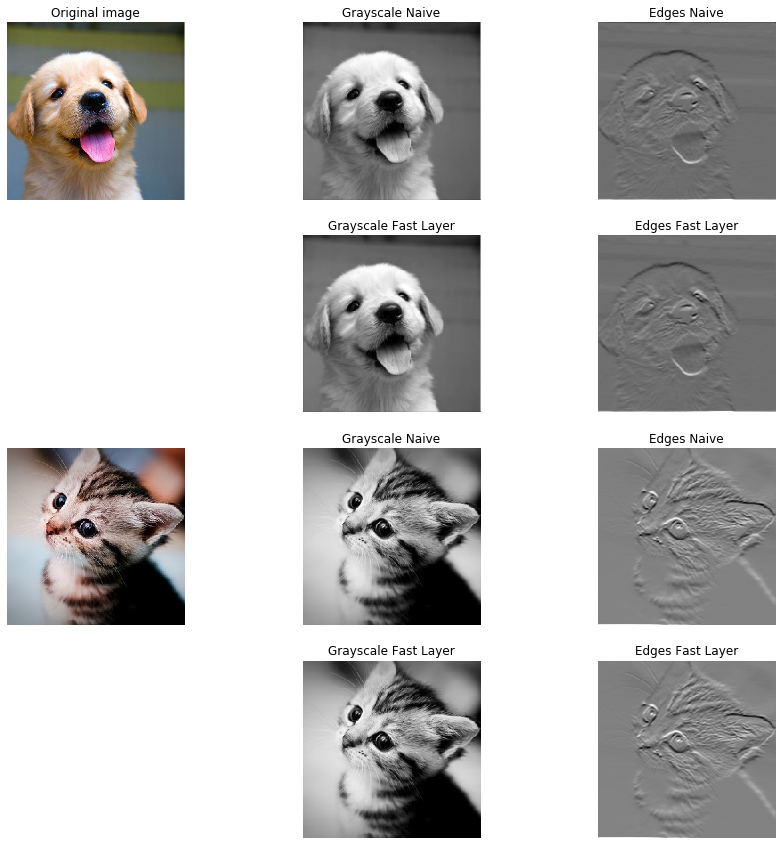

In [48]:
print('\nTesting:')
print('Naive  : %f seconds' % (t1 - t0))
print('Fast   : %f seconds' % (t2 - t1))
print('Speedup: %fx faster' % ((t1 - t0) / (t2 - t1)))

plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
 
# Show the original images and the results of the conv operation
plt.subplot(4, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(4, 3, 2)
imshow_noax(out_naive[0, :, :, 0])
plt.title('Grayscale Naive')
plt.subplot(4, 3, 3)
imshow_noax(out_naive[0, :, :, 1])
plt.title('Edges Naive')
plt.subplot(4, 3, 5)
imshow_noax(out_fast[0, :, :, 0])
plt.title('Grayscale Fast Layer')
plt.subplot(4, 3, 6)
imshow_noax(out_fast[0, :, :, 1])
plt.title('Edges Fast Layer')

plt.subplot(4, 3, 7)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(4, 3, 8)
imshow_noax(out_naive[1, :, :, 0])
plt.title('Grayscale Naive')
plt.subplot(4, 3, 9)
imshow_noax(out_naive[1, :, :, 1])
plt.title('Edges Naive')
plt.subplot(4, 3, 11)
imshow_noax(out_fast[1, :, :, 0])
plt.title('Grayscale Fast Layer')
plt.subplot(4, 3, 12)
imshow_noax(out_fast[1, :, :, 1])
plt.title('Edges Fast Layer')
plt.show()

---
---
# [Part 4] "Sandwich" Layer API

You've build a working Deep Neural Network before using Deep Neural Net API. And now we're adding a couple more layers to the mix.

Now you can just stack those in order like before, but you must've noticed that there's some kind of fixed order in stacking layers

Like in Deep Neural Net, in the hidden layers, after each affine layer, we always add an activation layer. 

And now in Covolutional Neural Network, after each conv layer, you either add an activation layer or add an activation folling by a pool layer.

Therefore, we can pre-stack those layer combinations into a concept of "sandwich" layers that combine multiple operations into commonly used patterns. 

---
## 1 - Affine-ReLU Block
Let's combine Affine layer with ReLU layer into Affine-ReLU Block

In [49]:
def affine_relu_forward(X, W, b):
    """
    Convenience layer that perorms an affine transform followed by a ReLU

    Inputs:
    - X: Input to the affine layer
    - W, b: Weights for the affine layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    
    # calculate layer score by calling affine forward function using X, W, and b
    act, fc_cache = affine_forward(X, W, b)
    
    # calculate activation score by calling relu forward function using layer act
    out, relu_cache = relu_forward(act)
    
    cache = (fc_cache, relu_cache)
    return out, cache

In [50]:
def affine_relu_backward(dout, cache):
    """
    Backward pass for the affine-relu convenience layer
    """    
    fc_cache, relu_cache = cache
    
    # calculate gradient by calling relu backward function using dout and relu_cache
    dact = relu_backward(dout, relu_cache)
    
     # calculate layer weights gradient by calling affine backward function using dact and fc_cache
    dX, dW, db = affine_backward(dact, fc_cache)
    
    return dX, dW, db

---
## 2 - Conv-ReLU Block

Next is Conv-ReLU Block

In [51]:
def conv_relu_forward(X, W, b, conv_param):
    """
    A convenience layer that performs a convolution followed by a ReLU.

    Inputs:
    - X: Input to the convolutional layer
    - W, b, conv_param: Weights and parameters for the convolutional layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    
    # calculate layer score by calling conv forward fast function using X, W, b, and conv_param
    # NOTE: USE FAST FUNCTION
    act, conv_cache = conv_forward_fast(X, W, b, conv_param)
    
    # calculate activation score by calling relu forward function
    out, relu_cache = relu_forward(act)
    
    cache = (conv_cache, relu_cache)
    return out, cache

In [52]:
def conv_relu_backward(dout, cache):
    """
    Backward pass for the conv-relu convenience layer.
    """
    conv_cache, relu_cache = cache
    
    # calculate gradient by calling relu backward function
    dact = relu_backward(dout, relu_cache)
    
    # calculate layer weights gradient by calling conv backward fast function using dact and conv_cache
    # NOTE: USE FAST FUNCTION
    dX, dW, db = conv_backward_fast(dact, conv_cache)
    
    return dX, dW, db

---
## 3 - Conv-ReLU-MaxPool Block

* Implement `conv_relu_pool_forward` 

* **Use the Fast Layer**

* **Use max pool** 

In [53]:
def conv_relu_pool_forward(X, W, b, conv_param, pool_param):
    """
    Convenience layer that performs a convolution, a ReLU, and a pool.

    Inputs:
    - X: Input to the convolutional layer
    - W, b, conv_param: Weights and parameters for the convolutional layer
    - pool_param: Parameters for the pooling layer

    Returns a tuple of:
    - out: Output from the pooling layer
    - cache: Object to give to the backward pass
    """
    
    # calculate layer score by calling conv forward fast function using X, W, b, and conv_param
    # NOTE: USE FAST FUNCTION
    act, conv_cache = conv_forward_fast(X, W, b, conv_param)
    
    # calculate activation score by calling relu forward function
    s, relu_cache = relu_forward(act)
    
    # calculate max pool score by calling pool forward fast function using s and pool_param
    # NOTE: USE FAST FUNCTION
    out, pool_cache = pool_forward_fast(s, pool_param, mode='max')
    
    cache = (conv_cache, relu_cache, pool_cache)    
    return out, cache

* Implement `conv_relu_pool_backward`

* **Use the Fast Layer**

* **Use max pool** 

In [55]:
def conv_relu_pool_backward(dout, cache):
    """
    Backward pass for the conv-relu-pool convenience layer
    """
    conv_cache, relu_cache, pool_cache = cache
    
    # propagate gradient to pooling layer by calling pool backward fast function
    # NOTE: USE FAST FUNCTION
    ds = pool_backward_fast(dout, pool_cache, mode='max')
    
    # calculate gradient by calling relu backward function
    dact = relu_backward(ds, relu_cache)
    
    # calculate layer weights gradient by calling conv backward fast function using dact and conv_cache
    # NOTE: USE FAST FUNCTION
    dX, dW, db = conv_backward_fast(dact, conv_cache)
    
    return dX, dW, db

---
---
# [Part 5] Three-layer ConvNet
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Complete the implementation of the `three_layer_convnet` function below.

<br>

A three-layer convolutional network with the following architecture:

<pre>
|                                |               |                  |
| <font color='red'>7x7 conv</font> - <font color=''>relu</font> - <font color='blue'>2x2 max pool</font> | <font color='brown'>affine</font> - <font color=''>relu</font> | <font color='brown'>affine</font> - <font color=''>softmax</font> |
|                                |               |                  |
|              1                 |       2       |        3         |
</pre>
<br>

The network operates on minibatches of data that have shape $(N, H, W, C)$ <br>
consisting of $N$ images, each with height $H$, width $W$, and $C$ input channels.

---
## 1 - Predict Function

Implement the predict function first, because we are going to use **predict** function inside the **training** function to track the **validation** accuracy 

**Implement Predict Function**

    * call forward conv-relu-pool function
    * call forward affine-relu function
    * call forward affine function

In [56]:
def predict_three_layer_convnet(X, W, b, params):    
    """
    Inputs:
    - X         : Input data, of shape(N, D)
    - W         : list of Weight
    - b         : list of biases
    - params    : parameter for convolution and pooling layer
    
    Output:
    - y_pred : list of class prediction
    """
        
    # get parameters
    conv_param, pool_param = params
        
    # Forward Pass Layer 1 :
    # calculate 1st layer score by calling conv-relu-pool forward function 
    # using X, W[0], b[0], conv_param, and pool_param
    act1, cache1 = conv_relu_pool_forward(X, W[0], b[0], conv_param, pool_param)

    # Forward Pass Layer 2 : 
    # calculate 2nd layer score by calling affine-relu forward function 
    # using act1, W[1], and b[1]
    act2, cache2 = affine_relu_forward(act1, W[1], b[1])

    # Forward Pass Layer 3 :
    # calculate 2nd layer score by calling affine forward function 
    # using act2, W[2], and b[2]
    act3, cache3 = affine_forward(act2, W[2], b[2])
    
    # take the maximum prediction from act3 and use that column to get the class          
    # use np.argmax with axis=-1 
    y_pred = np.argmax(act3, axis=-1)
    
    return y_pred

---
## 2 - Train Function

Now let's complete the training function

<br>

**Implement Training Function**

there are **four steps** in this training function

---

**1. Forward Pass**

    * call forward conv-relu-pool function
    * call forward affine-relu function
    * call forward affine function for the last layer
    * call softmax score function

**2. Calculate Loss**

    * call softmax_loss function
    * calculate loss with regularization


**3. Backward Pass**

    * call backward affine function for the last layer
    * call backward affine-relu function
    * call backward conv-relu-pool function

**4. Weight Update**

    * implement weight update
    * calculate the training and validation accuracy

In [60]:
def train_three_layer_convnet(X, y, X_val, y_val,
                              num_filters=32, filter_size=(7, 7),
                              hidden_dim=100, W=None, b=None,
                              lr=1e-4, lr_decay=0.95, reg=0.001, 
                              epochs=100,  batch_size=50, 
                              verbose=True, print_every=100):
    """
    Inputs:
    - X          : Array, shape (N, C, H, W) of training images
    - y          : Array, shape (N,) of labels for training images
    - X_val      : Array, shape (N_val, C, H, W) of validation images
    - y_val      : Array, shape (N_val,) of labels for validation images   
    - num_filters: Number of filters to use in the convolutional layer
    - filter_size: Width/height of filters to use in the convolutional layer
    - hidden_dim: Number of units to use in the fully-connected hidden layer
    - W          : list of Weight, if W is None, it will be initialized
    - b          : list of biases, if W is None, bias will be initialized
    - lr         : float, initial learning rate
    - lr_decay   : float, 0-1, decay rate to reduce learning rate each epoch
    - reg        : float, regularization rate
    - epochs     : int, number of training epoch
    - batch_size : int, number of batch used each step
    - verbose    : boolean, verbosity
    
    Outputs:
    - W          : list of trained Weights
    - b          : list of trained biases
    - history    : list of training history [loss, train_acc, val_acc]
    - params     : tuple of convolution and pooling layer parameters
    
    """
    
    
       
    # extract input size
    num_train, H_in, W_in, C_in = X.shape    
    
    # check if data train is divisible by batch size
    assert num_train % batch_size==0, "data train "+str(num_train)+" is not divisible by batch size"+str(batch_size)
    
    
    # total iteration per epoch
    num_iter = num_train // batch_size
    
    #start iteration counts
    it = 0
    
    
    # assume y takes values 0...K-1 where K is number of classes
    num_classes = np.max(y) + 1 
    
    # extract filter size
    H_f, W_f = filter_size    
    
    # set stride and padding
    f_stride = 1
    pad = (H_f - 1)//2

    
    ## ------------------------- start your code here -------------------------

    
    # calculate output convolution size (1st layer activation)
    # output conv height = 1 + (input height + 2 * padding size - filter height)/ filter stride
    conv_H = 1+(H_in+(2*pad)-H_f)//f_stride
    
    # output conv width = 1 + (input width + 2 * padding size - filter width) / filter stride
    conv_W = 1+(W_in+(2*pad)-W_f)//f_stride
    
    
    
    # set pool size and stride
    pool_size   = 2
    pool_stride = 2
    
    # calculate output pool size (1st layer pool) based on conv layer output size
    # output pool height  = 1 + (conv height - pool size) / pool stride
    pool_H = 1+(conv_H-pool_size)//pool_stride
    
    # output pool width  =  1 + (conv width - pool size) / pool stride 
    pool_W = 1+(conv_W-pool_size)//pool_stride

    # initialize weights and biases
    if W is None:        
        W0 = 1e-3 * np.random.randn(num_filters, H_f, W_f, C_in).astype(np.float32)
        W1 = 1e-3 * np.random.randn(num_filters*pool_H*pool_W, hidden_dim).astype(np.float32)
        W2 = 1e-3 * np.random.randn(hidden_dim, num_classes).astype(np.float32)
        W = [W0, W1, W2]
        
        
    if b is None:
        b0 = np.zeros(num_filters).astype(np.float32)
        b1 = np.zeros((1,hidden_dim)).astype(np.float32)
        b2 = np.zeros((1,num_classes)).astype(np.float32)
        b = [b0, b1, b2]
        
        
    # set training parameters   
    conv_param = {'stride': 1, 'pad': pad}
    pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}
    
        
    # Run stochastic gradient descent to optimize W
    loss_history = []
    train_acc_history = []
    val_acc_history = []
    dW = {}
    db = {}
    dx = {}
    
                     
    print('start training')
    
    for ep in range(epochs):
      
       # Shuffle data train index
        train_rows = np.arange(num_train)
        np.random.shuffle(train_rows)
        
        # split index into mini batches
        id_batch = np.split(train_rows, num_iter)
  
        for batch in id_batch:
      
            X_batch = X[batch]
            y_batch = y[batch]
        

            # ------------------------------------------------
            # 1. Forward Pass
            # ------------------------------------------------
            
            
            # Forward Pass Layer 1 (Conv):
            # calculate 1st layer score by calling conv-relu-pool forward function 
            # using X_batch, W[0], b[0], conv_param, and pool_param
            act1, cache1 = conv_relu_pool_forward(X_batch, W[0], b[0], conv_param, pool_param)

            # Forward Pass Layer 2 (Affine): 
            # calculate 2nd layer score by calling affine-relu forward function 
            # using act1, W[1], and b[1]
            act2, cache2 = affine_relu_forward(act1, W[1], b[1])

            # Forward Pass Layer 3 (Affine):
            # calculate 2nd layer score by calling affine forward function 
            # using act2, W[2], and b[2]
            act3, cache3 = affine_forward(act2, W[2], b[2])

            # calculate softmax score by calling softmax function using act3 
            softmax_score = softmax(act3)

            # ------------------------------------------------
            # 2. Calculate Loss
            # ------------------------------------------------
      
            # evaluate loss and gradient by calling softmax_loss function using softmax_score and y_batch
            loss, dout = softmax_loss(softmax_score, y_batch)

            # add regularization to the loss:
            #    for each weights, calculate the sum square, multiply regularization strength
            #    then add it to the loss
            for w in W:
                loss += reg * np.sum(w*w)

            # append the loss history
            loss_history.append(loss)
        
        

            # ------------------------------------------------
            # 3. Backward Pass
            # ------------------------------------------------    
            
            # Backward Pass Layer 3 (Affine):
            # calculate layer 3 gradients by calling affine backward function using dout and cache3
            dact3, dW[2], db[2] = affine_backward(dout, cache3)

            # Forward Pass Layer 2 (Affine): 
            # calculate layer 2 gradients by calling affine-relu backward function using dact3 and cache2
            dact2, dW[1], db[1] = affine_relu_backward(dact3, cache2)

            # Forward Pass Layer 1 (Conv): 
            # calculate layer 1 gradients by calling conv-relu-pool backward function using dact2 and cache1
            dact1, dW[0], db[0] = conv_relu_pool_backward(dact2, cache1)



            # ------------------------------------------------
            # 4. Weight Update
            # ------------------------------------------------    

            # add regularization to the gradient:
            #    for each gradient dW, add with twice of the weight multiplied by regularization strength
            #    dwi = dwi + 2 * reg * wi
            # loop over W
            for i in range(len(W)):   
                dW[i] += 2*reg*W[i]


            # perform parameter update by subtracting W[i] and b[i] for each layer with a fraction of dW[i] and db[i]
            # according to the learning rate
            # loop over W
            for i in range(len(W)):    
                # w_i = w_i - lr * dw_i
                W[i] -= lr*dW[i]
    
                # b_i = b_i - lr * db_i
                b[i] -= lr*db[i]


            # iteration count
            it +=1

            if verbose and it % print_every == 1:
                print ('iteration',it,'/',num_iter,'\t(epoch', ep+1,'/',epochs, '): \tloss =', loss)
                
                
        # At the end of one epoch
        # 1. Check accuracy
        #    calculate the training accuracy by calling predict_three_layer_convnet function on X_batch
        #    and compare it to y_batch. Then calculate the mean correct (accuracy in range 0-1)
        train_acc = (predict_three_layer_convnet(X_batch, W, b, (conv_param, pool_param)) == y_batch).mean()
        train_acc_history.append(train_acc)

        # 2. Calculate the training accuracy by calling predict_three_layer_convnet function on X_val
        #    and compare it to y_val. Then calculate the mean correct (accuracy in range 0-1)
        val_acc = (predict_three_layer_convnet(X_val, W, b, (conv_param, pool_param)) == y_val).mean()
        val_acc_history.append(val_acc)

        # 3. Decay learning rate
        #    multiply learning rate with decay
        lr *= lr_decay
            
            
    ## ------------------------- your code end here ----------------------------
    
    history = [loss_history, train_acc_history, val_acc_history]
    
    if verbose:
      print('Training done')
      
    params = (conv_param, pool_param)
    
    return W, b, history, params

---
## 3 - Train a 3-Layer ConvNet

By training the three-layer convolutional network for **one epoch**, you should achieve greater than **50% accuracy** on the training set

<font color='red'>*nb: it took **several minutes** just to run 1 epoch*

In [61]:
t1 = time()
W_conv, b_conv, history, params = train_three_layer_convnet(X_train, y_train, 
                                                            X_val, y_val,
                                                            num_filters=36, filter_size=(7, 7),
                                                            hidden_dim=500, lr=1e-2, 
                                                            lr_decay=0.95, reg=0.005, 
                                                            epochs=1, batch_size=100, 
                                                            verbose=True, print_every=20)
                                                     
t2 = time()

training_time = (t2-t1)/60
print('\ntraining time: %0.2f minutes' % training_time)

start training
iteration 1 / 490 	(epoch 1 / 1 ): 	loss = 2.325681343531208
iteration 21 / 490 	(epoch 1 / 1 ): 	loss = 2.3192809858775227
iteration 41 / 490 	(epoch 1 / 1 ): 	loss = 2.047123825893939
iteration 61 / 490 	(epoch 1 / 1 ): 	loss = 2.288102993136998
iteration 81 / 490 	(epoch 1 / 1 ): 	loss = 1.9568476320759334
iteration 101 / 490 	(epoch 1 / 1 ): 	loss = 1.9466060192596404
iteration 121 / 490 	(epoch 1 / 1 ): 	loss = 2.061160731463453
iteration 141 / 490 	(epoch 1 / 1 ): 	loss = 1.9424601800141554
iteration 161 / 490 	(epoch 1 / 1 ): 	loss = 2.0350024653402117
iteration 181 / 490 	(epoch 1 / 1 ): 	loss = 1.6434873870649342
iteration 201 / 490 	(epoch 1 / 1 ): 	loss = 1.684227447758403
iteration 221 / 490 	(epoch 1 / 1 ): 	loss = 1.5914675187108602
iteration 241 / 490 	(epoch 1 / 1 ): 	loss = 1.4227457729012785
iteration 261 / 490 	(epoch 1 / 1 ): 	loss = 1.7302743340722062
iteration 281 / 490 	(epoch 1 / 1 ): 	loss = 1.717810667396052
iteration 301 / 490 	(epoch 1 / 1 ): 

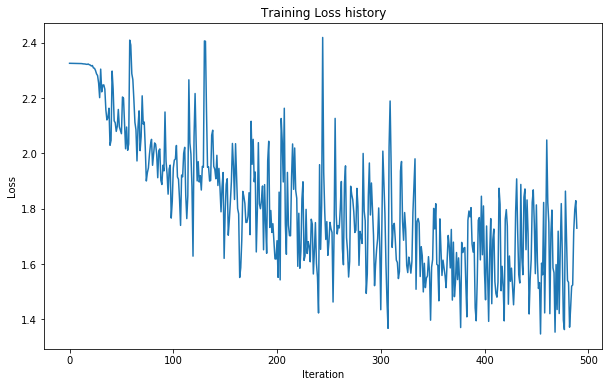

In [62]:
loss, train_acc, val_acc = history

plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss history')
plt.show()

---
## 4 - Training Accuracy
Calculate the train-validation accuracy

In [63]:
print('Training Accuracy   = %.1f%%' % (train_acc[-1]*100))


import sklearn
from sklearn.metrics import accuracy_score

y_pred = predict_three_layer_convnet(X_val, W_conv, b_conv, params)
accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
print('Validation Accuracy = %.1f%%' % (accuracy*100))


Training Accuracy   = 52.0%
Validation Accuracy = 48.0%


---
---
# [Part 6] Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following codes

In [66]:
# %load vis_utils.py
from math import sqrt, ceil
import numpy

def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.

    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = numpy.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = numpy.min(img), numpy.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    # grid_max = numpy.max(grid)
    # grid_min = numpy.min(grid)
    # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
    return grid

def vis_grid(Xs):
    """ visualize a grid of images """
    (N, H, W, C) = Xs.shape
    A = int(ceil(sqrt(N)))
    G = numpy.ones((A*H+A, A*W+A, C), Xs.dtype)
    G *= numpy.min(Xs)
    n = 0
    for y in range(A):
        for x in range(A):
            if n < N:
                G[y*H+y:(y+1)*H+y, x*W+x:(x+1)*W+x, :] = Xs[n,:,:,:]
                n += 1
    # normalize to [0,1]
    maxg = G.max()
    ming = G.min()
    G = (G - ming)/(maxg-ming)
    return G
  
def vis_nn(rows):
    """ visualize array of arrays of images """
    N = len(rows)
    D = len(rows[0])
    H,W,C = rows[0][0].shape
    Xs = rows[0][0]
    G = numpy.ones((N*H+N, D*W+D, C), Xs.dtype)
    for y in range(N):
        for x in range(D):
            G[y*H+y:(y+1)*H+y, x*W+x:(x+1)*W+x, :] = rows[y][x]
    # normalize to [0,1]
    maxg = G.max()
    ming = G.min()
    G = (G - ming)/(maxg-ming)
    return G





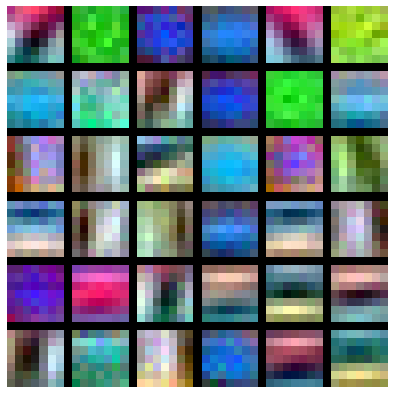

In [67]:
grid = visualize_grid(W_conv[0])
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(7, 7)

# [Part 7] Deep ConvNet API

You've build and train a Three layer Convolutional Neural Network

But looks like we're back at the begining where we build a specific training function for each architecture. Which is really not flexible if we want to try different architecture and depth of the network.

So now we're going to build a Deep Convolutional Neural Network API, much more like the popular Deep Learning Framework available, so that we can design and train a more deep and complex ConvNet with much ease.

---
## 1 - Weight Initializer

First, let's define the weight initialization function like in the Deep Neural Net API before

But now, apart from the affine weight initializer, we add another weight initializer for the filter of the convolution layer

In [68]:
def init_weights_affine(d_in, d_out, std=1e-3):
    """
    Weight initialization for affine layer
    
    Inputs:
    - d_in  : int, number of input dimension
    - d_out : int, number of output dimension
    - std   : standard deviation for generating weights
    - seed  : random seed
    
    Outputs:
    - W: list of Weights
    - b: list of biases
    """
    
    W = std * np.random.randn(d_in, d_out).astype(np.float32)
    b = np.zeros((1, d_out)).astype(np.float32)

    return W, b

In [69]:
def init_weights_conv(filter_size, std=1e-3):
    """
    Weight initialization for convolution layer
    
    Inputs:
    - d_filter_size  : tuple of filter size (nF, Hf, Wf, Cf)
    - std            : standard deviation for generating weights
    - seed           : random seed
    
    Outputs:
    - W: list of Weights
    - b: list of biases
    """  
    
    num_filter, H_f, W_f, C_f = filter_size

    W = std * np.random.randn(num_filter, H_f, W_f, C_f).astype(np.float32)
    b = np.zeros(num_filter).astype(np.float32)

    return W, b

---
## 2 - Model Initializer

Next, let's start with Model Initialization Function

This function will receive a list of designed neural net **architecture**, and it will initialize weights according to the layer type and parameters given in the designed architecture.

The architecture feed in is a list of layers that is stacked in a **Sequential Model** fashion. The Layer is also a list of named layer type followed by its required parameters.

The Model initializer receive **4 kinds** of layer:

<br>
<font size=10>
<table border=1 solid>
  <tr border=1>
    <th><font size=2>      Layer Name    </font></th>
    <th><font size=2>      Definition and Parameters    </font></th>
    <th colspan=2><font size=2>      Parameters    </font></th>
  </tr>
  <tr>
    <td><font size=3>      <pre>'input'</pre>    </font></td>
    <td><font size=2>      input layer, <br>to determine the input shape    </font></td>
    <td><font size=3>      <pre>(h, w, c)</pre>    </font></td>
    <td><font size=2>      tuple of input dimension     </font></td>
  </tr>
  <tr>
    <td><font size=3>      <pre>'affine'</pre>    </font></td>
    <td><font size=2>      affine layer, <br>followed by relu activation    </font></td>
    <td><font size=3>      <pre>d_out</pre>    </font></td>
    <td><font size=2>      integer, <br>number of output neurons     </font></td>
  </tr>
  <tr>
    <td rowspan=4><font size=3>      <pre>'conv'</pre>    </font></td>
    <td rowspan=4><font size=2>      convolution layer, <br>followed by relu activation    </td>
    <td><font size=3>      <pre>(h, w, c)</pre>    </font></td>
    <td><font size=2>      tuple of filter dimension     </font></td>
  </tr>
  <tr>
    <td><font size=3>      <pre>f</pre>    </font></td>
    <td><font size=2>      integer, <br>number of filter     </font></td>
  </tr>
  <tr>
    <td><font size=3>      <pre>s</pre>   </font></td>
    <td><font size=2>      integer, <br>size of stride     </font></td>
  </tr>
  <tr>
    <td><font size=3>      <pre>p</pre>    </font></td>
    <td><font size=2>      integer, <br>size of padding     </font></td>
  </tr>
  <tr></tr>
  <tr>
    <td rowspan=2><font size=3>      <pre>'pool'</pre>    </font></td>
    <td rowspan=2><font size=2>      pooling layer </font></td>
    <td><font size=3>      <pre>(w, h)</pre>   </font></td>
    <td><font size=2>      tuple of pool size    </font> </td>
  </tr>
  <tr>
    <td><font size=3>      <pre>s</pre>    </font></td>
    <td><font size=2>      integer, <br>size of stride     </font></td>
  </tr>
</table>

</font>

In [70]:
def init_model(architecture):    
  
    """
    Inputs:
    - architecture  : list of layer name and paramters
    
    
    Outputs:
    - neural net model, a tuple of:
      - architecture: list of layer name and paramters
      - W           : list of trained Weights
      - b           : list of trained biases
      - params      : list of compact layer parameters
    
    """
    
    
    # define output container
    W = {}
    b = {}
    params = {}
    
    # reset input shape from previous layer
    h, w, c = 0, 0, 0
    d_prev = 0
    
    # the first layer must be input layer
    assert(architecture[0][0]=='input')
    
    
    # loop read list of layer
    for i in range(len(architecture)):
      
        # read the layer information
        layer = architecture[i]
        
        # if the layer is input, get the input shape
        if layer[0]=='input':
            
            h, w, c = layer[1]
            
            
        # if the layer is affine layer,
        # initialize weight and bias
        elif layer[0]=='affine':
          
            # get the previous output shape
            if d_prev==0:
                d_prev = h*w*c
                
            # get this layer output shape
            d_out = layer[1]
            
            # initialize weight and bias
            W[i], b[i] = init_weights_affine(d_prev, d_out)
            
            # set this layer output shape as previous output shape 
            # for the next layer
            d_prev = d_out
            
            
        # if the layer is convolution layer
        # initialize weight and bias
        elif layer[0]=='conv':
            
            # get conv layer parameter
            filter_size, nf, stride, pad = layer[1:]
            
            # get filter shape
            hf, wf = filter_size
            
            # calculate this layer output shape
            h = 1 + (h + 2 * pad - hf) // stride
            w = 1 + (w + 2 * pad - wf) // stride
            
            # initialize weight and bias
            W[i], b[i] = init_weights_conv((nf, hf, wf, c))
            
            # set this layer output shape as previous output shape 
            c = nf
            
            # compact the parameters
            params[i] = {'stride': stride, 'pad':pad}
            
            
        # if the layer is pooling layer
        elif layer[0]=='pool':
            
            # get pool layer parameter
            pool_size, stride = layer[1:]
            
            # get pooling size
            hp, wp = pool_size
            
            # calculate this layer output shape
            h = (h - hp) // stride + 1
            w = (w - hp) // stride + 1            
            
            # compact the parameters
            params[i] = {'pool_height': pool_size[0], 'pool_width': pool_size[1], 'stride': stride}
            
            
    # combine the weights and its parameters into a tuple of model
    model = (architecture, W, b, params)
            
    # return the network model
    return model

---
## 3 - Predict Function

Now let's build the predict function 

you should already be very familiar with this implementation

**Implement Predict Function**

    * loop call forward function for each hidden layer weights
    * call forward function for the last layer

In [71]:
def predict(model, X):    
    """
    Inputs:
    - model      : Network model architecture and weights
    - X    : Input data, of shape(N, D)
    
    Output:
    - y_pred : list of class prediction
    """
    
    # get the model architecture and weights
    architecture, W, b, params = model
    
    # get number of layers
    n_layer = len(architecture)
    
    # set input X as the first activation
    act = X    
    
    
    # loop i over n_layer-1
    for i in range(n_layer-1):
      
      # get layer architecture
      layer = architecture[i]
      
      
      # check layer type
      if layer[0]=='affine':
        # call affine relu forward function with input act, W[i], and b[i]
        act, _ = affine_relu_forward(act, W[i], b[i])
        
      elif layer[0]=='conv':        
        # call conv relu forward function with input act, W[i], b[i], and params[i]
        act, _ = conv_relu_forward(act, W[i], b[i], params[i])
        
      elif layer[0]=='pool':
        # call pool forward fast function with input act and params[i]
        # NOTE: USE FAST FUNCTION
        act, _ = pool_forward_fast(act, params[i])
        

    # calculate last layer score by calling affine forward function using act, W[i+1], and b[i+1]
    last_layer, _ = affine_forward(act, W[i+1], b[i+1])
    
    # take the maximum prediction from the last layer and use that column to get the class     
    # use np.argmax with axis=-1 
    y_pred = np.argmax(last_layer, axis=-1)
    
    return y_pred

---
## 4 - Training Function

Now on to the training function

you should already be very familiar with this implementation

**Implement Training Function**

there are **four steps** in this training function

---

**1. Forward Pass**

    * loop over hidden layer [for len(W)-1]
        * call layer forward function acording to the architecure
    * call affine forward function for the last layer
    * call softmax score function
    

**2. Calculate Loss**

    * call softmax_loss function
    * loop over weights [for W]
        * calculate loss with regularization


**3. Backward Pass**

    * call affine backward function for the last layer
    * loop over hidden layer [from len(W)-2 to 0]
        * call layer backward function acording to the architecure

**4. Weight Update**

    * loop over weights [for W]
        * implement weight update
    * calculate the training and validation accuracy

In [72]:
def train(model, X, y, X_val, y_val,
          lr=1e-4, lr_decay=0.95, 
          reg=0.001, epochs=100, 
          batch_size=50, 
          verbose=True, print_every=100):

  
    """
    Inputs:
    - model      : Network model architecture and weights
    - X          : Array, shape (N, C, H, W) of training images
    - y          : Array, shape (N,) of labels for training images
    - X_val      : Array, shape (N_val, C, H, W) of validation images
    - y_val      : Array, shape (N_val,) of labels for validation images  
    - lr         : float, initial learning rate
    - lr_decay   : float, 0-1, decay rate to reduce learning rate each epoch
    - reg        : float, regularization rate
    - epochs     : int, number of training epoch
    - batch_size : int, number of batch used each step
    - verbose    : boolean, verbosity
    
    Outputs:
    - model      : Network model architecture and weights
    - history    : list of training history [loss, train_acc, val_acc]
    
    """
      
    
    # extract input size
    num_train, H_in, W_in, C_in = X.shape
    
    
    # check if data train is divisible by batch size
    assert num_train % batch_size==0, "data train "+str(num_train)+" is not divisible by batch size"+str(batch_size)
    
    
    # get the model architecture
    architecture, W, b, params = model        
    
    # get the layer number (including output layer)
    n_layer = len(architecture)
    
    
    # assume y takes values 0...K-1 where K is number of classes
    num_classes = np.max(y) + 1
    
    # total iteration per epoch
    num_iter = num_train // batch_size
    
    #start iteration counts
    it = 0
    
    
    # Run stochastic gradient descent to optimize W
    loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    dW = {}
    db = {}
    dx = {}
    
                     
    ## ------------------------- start your code here --------------------------
    
    print('start training')
    
    for ep in range(epochs):
      
        # Shuffle data train index
        train_rows = np.arange(num_train)
        np.random.shuffle(train_rows)
        
        # split index into mini batches
        id_batch = np.split(train_rows, num_iter)
  
        for batch in id_batch:
      
            X_batch = X[batch]
            y_batch = y[batch]
        
            # store all cache in dictionary
            cache = {}

            # first layer activation input is X_batch
            act = X_batch


            # ------------------------------------------------
            # 1. Forward Pass
            # ------------------------------------------------

            # loop i over n_layer-1
            for i in range(n_layer-1):
              
                # get layer architecture                
                layer = architecture[i]
                
                
                # check layer type
                if layer[0]=='affine':
                  # call affine relu forward function with input act, W[i], and b[i]
                    act, cache[i] = affine_relu_forward(act, W[i], b[i])

                elif layer[0]=='conv':        
                  # call conv relu forward function with input act, W[i], b[i], and params[i]
                    act, cache[i] = conv_relu_forward(act, W[i], b[i], params[i])

                elif layer[0]=='pool':
                  # call pool forward fast function with input act and params[i]
                  # NOTE: USE FAST FUNCTION
                    act, cache[i] = pool_forward_fast(act, params[i])

 
            # calculate last layer score by calling affine forward function using activation act, W[i+1], and b[i+1] 
            last_layer, cache[i+1] = affine_forward(act, W[i+1], b[i+1])

            # calculate softmax score by calling softmax function using last_layer score
            softmax_score = softmax(last_layer)

            # ------------------------------------------------
            # 2. Calculate Loss
            # ------------------------------------------------

            # evaluate loss and gradient by calling softmax_loss function using softmax_score and y_batch
            loss, dout = softmax_loss(softmax_score, y_batch)

            # add regularization to the loss:
            #    for each weights, calculate the sum square, multiply regularization strength
            #    then add it to the loss
            for w in W:
                loss += reg * np.sum(w*w)

            # append the loss history
            loss_history.append(loss)


            # ------------------------------------------------
            # 3. Backward Pass
            # ------------------------------------------------    

            # dictionary to contain all gradients
            dW = {}
            db = {}

            # calculate last weights gradient by calling affine backward function using dout and cache[n_layer-1]
            dact, dW[n_layer-1], db[n_layer-1] = affine_backward(dout, cache[n_layer-1])

            #loop i from n_layer-2 down to 0
            for i in range(n_layer-2,-1,-1):
      
                # get layer architecture                                
                layer = architecture[i]

                # check layer type
                if layer[0]=='affine':
                  # call affine relu backward function with input dact and cache[i]
                    dact, dW[i], db[i] = affine_relu_backward(dact, cache[i])
                  
                    
                elif layer[0]=='conv':
                  # call conv relu backward function with input dact and cache[i]
                    dact, dW[i], db[i] = conv_relu_backward(dact, cache[i])


                elif layer[0]=='pool':
                  # call pool backward fast function with input dact and cache[i]
                  # NOTE: USE FAST FUNCTION
                    dact = pool_backward_fast(dact, cache[i])


            # ------------------------------------------------
            # 4. Weight Update
            # ------------------------------------------------ 
      
      
            # add regularization to the gradient:
            #    for each gradient dW, add with twice of the weight multiplied by regularization strength
            #    dwi = dwi + 2 * reg * wi
            # loop over W
            for i in W.keys():   
                dW[i] += 2 * reg * W[i]


            # perform parameter update by subtracting W[i] and b[i] for each layer with a fraction of dW[i] and db[i]
            # according to the learning rate
            # loop over W
            for i in W.keys():    
                W[i] -= lr * dW[i]
                b[i] -= lr * db[i]



            # iteration count
            it +=1

            if verbose and it % print_every == 1:
                print ('iteration',it,'/',num_iter,'\t(epoch', ep+1,'/',epochs, '): \tloss =', loss)
                   
                
        # record model at this epoch    
        model_epoch = (architecture, W, b, params) 
        
        # At the end of one epoch
        # 1. Check accuracy
        #    calculate the training accuracy by calling predict function on model_epoch and X_batch
        #    and compare it to y_batch. Then calculate the mean correct (accuracy in range 0-1)
        train_acc = (predict(model_epoch, X_batch) == y_batch).mean()
        train_acc_history.append(train_acc)

        # 2. Calculate the training accuracy by calling predict function on model_epoch and X_val
        #    and compare it to y_val. Then calculate the mean correct (accuracy in range 0-1)
        val_acc = (predict(model_epoch, X_val) == y_val).mean()
        val_acc_history.append(val_acc)

        # 3. Decay learning rate
        #    multiply learning rate with decay
        #    see sigmoid train function
        lr *= lr_decay

        
    ## ------------------------- your code end here ----------------------------
    
        
    # store trained weights in model
    model = (architecture, W, b, params)      
    
    # store all trining history
    history = [loss_history, train_acc_history, val_acc_history]
    
    # return model and training history
    return model, history

---
---
# [Part 8] Train Deep ConvNet

---
## 1 - Define Model
Now let's try our training function

we'll use the same the three-layer convnet architecture as before

In [73]:
# architecture options:
# input , input_size
# conv  , conv_size , num_filter, stride, pad
# pool  , pool_size , stride
# affine, hidden_size

architecture =[
    ['input' , (32, 32, 3)],
    ['conv'  , (7, 7), 36, 1, 3],
    ['pool'  , (2, 2), 2],
    ['affine', 500],
    ['affine', 10]
]

Now print the architecture list

In [74]:
for i in range(len(architecture)):
    layer = architecture[i]
    print('layer',i,':',layer)

layer 0 : ['input', (32, 32, 3)]
layer 1 : ['conv', (7, 7), 36, 1, 3]
layer 2 : ['pool', (2, 2), 2]
layer 3 : ['affine', 500]
layer 4 : ['affine', 10]


next, initialize the model

In [75]:
model = init_model(architecture)

---
## 2 -  Train Model

Now we train the model

you should get similar result as before

In [76]:
t1 = time()
model, history2 = train(model, X_train, y_train, X_val, y_val, 
                       lr=1e-2,  lr_decay=0.95, 
                       reg=0.005, epochs=1, batch_size=100, 
                       verbose=True, print_every=20)
                                                     
t2 = time()


training_time = (t2-t1)/60
print('\ntraining time: %0.2f minutes' % training_time)

start training
iteration 1 / 490 	(epoch 1 / 1 ): 	loss = 2.4324092806412336
iteration 21 / 490 	(epoch 1 / 1 ): 	loss = 2.421207254365865
iteration 41 / 490 	(epoch 1 / 1 ): 	loss = 2.1288785978854956
iteration 61 / 490 	(epoch 1 / 1 ): 	loss = 2.2883635012712658
iteration 81 / 490 	(epoch 1 / 1 ): 	loss = 1.9572331171671538
iteration 101 / 490 	(epoch 1 / 1 ): 	loss = 2.0100737427049835
iteration 121 / 490 	(epoch 1 / 1 ): 	loss = 1.9849737753388155
iteration 141 / 490 	(epoch 1 / 1 ): 	loss = 2.1867030655072934
iteration 161 / 490 	(epoch 1 / 1 ): 	loss = 1.950581940409339
iteration 181 / 490 	(epoch 1 / 1 ): 	loss = 2.11684658786582
iteration 201 / 490 	(epoch 1 / 1 ): 	loss = 1.8515326932433842
iteration 221 / 490 	(epoch 1 / 1 ): 	loss = 2.0101031053328744
iteration 241 / 490 	(epoch 1 / 1 ): 	loss = 1.7765039301396526
iteration 261 / 490 	(epoch 1 / 1 ): 	loss = 2.0510081478475977
iteration 281 / 490 	(epoch 1 / 1 ): 	loss = 1.9313760705371104
iteration 301 / 490 	(epoch 1 / 1 )

---
## 3 - Training Accuracy
Calculate the train-validation accuracy

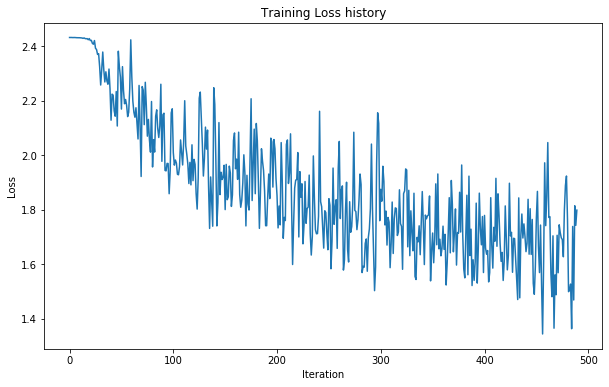

In [77]:
loss, train_acc, val_acc = history2

plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss history')
plt.show()

In [78]:
y_pred = predict(model, X_val)
accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
print('Validation Accuracy = %.1f%%' % (accuracy*100))

Validation Accuracy = 42.6%
